In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import glob

from loop_helpers import read_loop_frame, monte_carlo, mk_sum, loop_monte_carlo

from NucFrames.NucFrames import NucFrames

np.random.seed(42)

In [3]:
frame_files = glob.glob("/mnt/SSD/LayeredNuc/frames/*.hdf5") # Change this to the directory containing .hdf5 files downloaded from GEO.
cell_labels = [ "Cell {}".format(i + 1) for i, _ in enumerate(frame_files) ]
nfs = NucFrames(frame_files)

In [4]:
# Load the loops into a dataframe
loop_file = "/home/lpa24/dev/cam/data/rao_et_al_data/GSE63525_CH12-LX_HiCCUPS_looplist_with_motifs.txt" # Change the location of this file. It is downloaded from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
df = read_loop_frame(loop_file)
cis = df[df["chr1"] == df["chr2"]]
trans = df[df["chr1"] != df["chr2"]]

In [5]:
new_cis = []
for chrm, df in cis.groupby('chr1'):
    idx_a, _, valid_a = nfs.chrm_bp_to_idx(chrm, df["a"].values.astype(np.int32))
    idx_b, _, valid_b = nfs.chrm_bp_to_idx(chrm, df["b"].values.astype(np.int32))
    valid = np.logical_and(valid_a, valid_b)

    idx_a = idx_a[valid]
    idx_b = idx_b[valid]
    
    new_df = df[valid].copy()
    
    new_df["idx_a"] = idx_a
    new_df["idx_b"] = idx_b
    new_cis.append(new_df)
cis = pd.concat(new_cis)
    

Chromosome 1
Highest possible sum from sampling: 5234
Lowest possible sum from sampling: 1635
Max from background: 3432, loop value: 3976, theoretical max: 6670


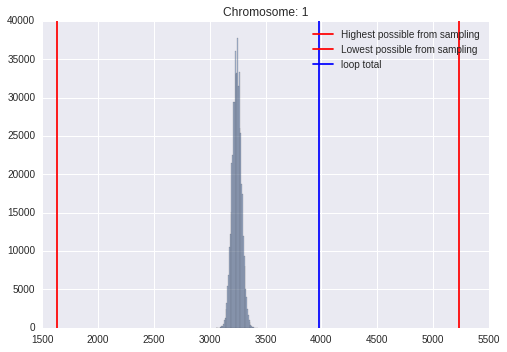

Chromosome 10
Highest possible sum from sampling: 3974
Lowest possible sum from sampling: 1271
Max from background: 2695, loop value: 2942, theoretical max: 4814


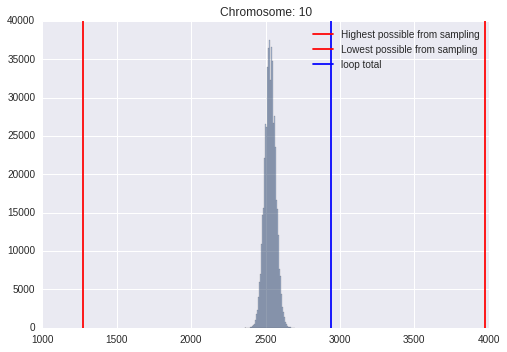

Chromosome 11
Highest possible sum from sampling: 7934
Lowest possible sum from sampling: 2480
Max from background: 5553, loop value: 6114, theoretical max: 9773


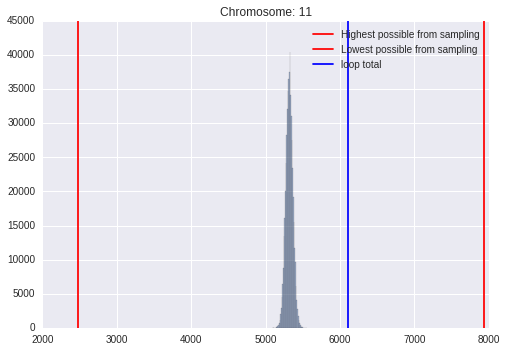

Chromosome 12
Highest possible sum from sampling: 3194
Lowest possible sum from sampling: 825
Max from background: 1949, loop value: 2193, theoretical max: 4147


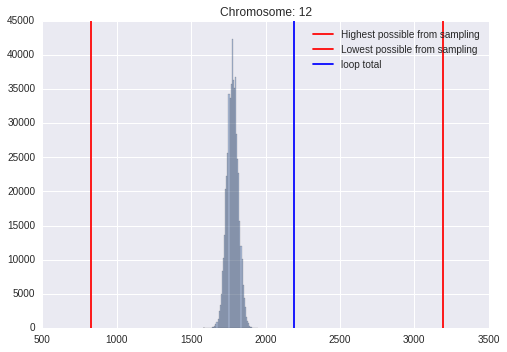

Chromosome 13
Highest possible sum from sampling: 3043
Lowest possible sum from sampling: 828
Max from background: 1910, loop value: 2125, theoretical max: 4002


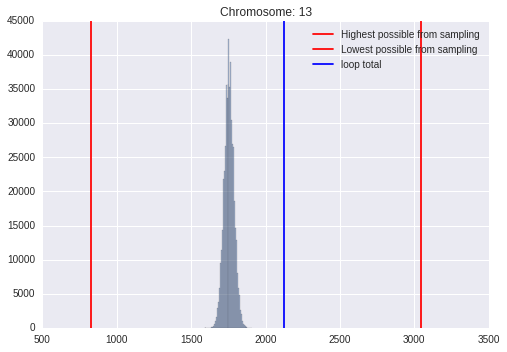

Chromosome 14
Highest possible sum from sampling: 2828
Lowest possible sum from sampling: 1049
Max from background: 1938, loop value: 2127, theoretical max: 3683


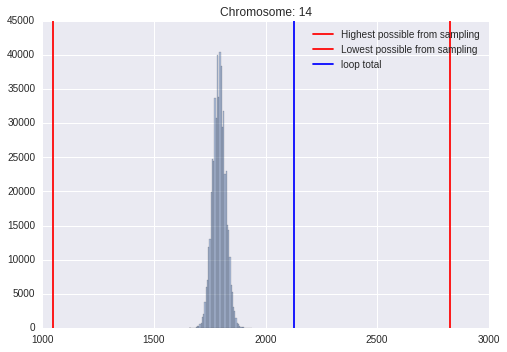

Chromosome 15
Highest possible sum from sampling: 3620
Lowest possible sum from sampling: 1087
Max from background: 2363, loop value: 2634, theoretical max: 4756


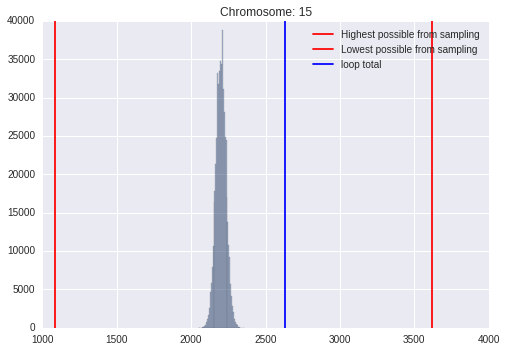

Chromosome 16
Highest possible sum from sampling: 3990
Lowest possible sum from sampling: 1380
Max from background: 2726, loop value: 2931, theoretical max: 5249


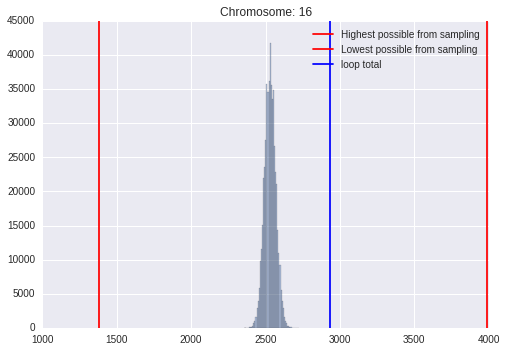

Chromosome 17
Highest possible sum from sampling: 2456
Lowest possible sum from sampling: 837
Max from background: 1654, loop value: 1780, theoretical max: 3277


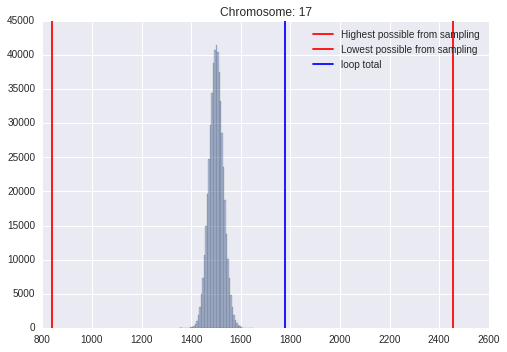

Chromosome 18
Highest possible sum from sampling: 2562
Lowest possible sum from sampling: 1032
Max from background: 1938, loop value: 2003, theoretical max: 3132


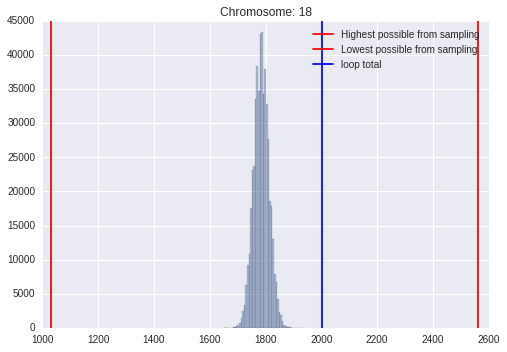

Chromosome 19
Highest possible sum from sampling: 2342
Lowest possible sum from sampling: 1018
Max from background: 1796, loop value: 1889, theoretical max: 2813


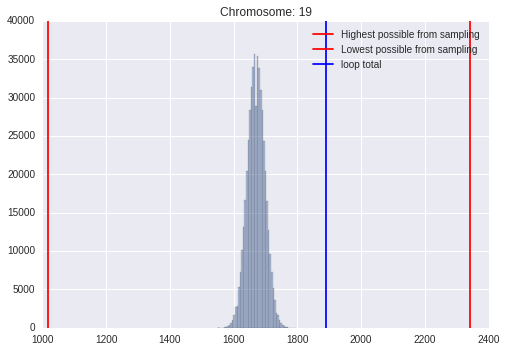

Chromosome 2
Highest possible sum from sampling: 6700
Lowest possible sum from sampling: 2148
Max from background: 4608, loop value: 5076, theoretical max: 8033


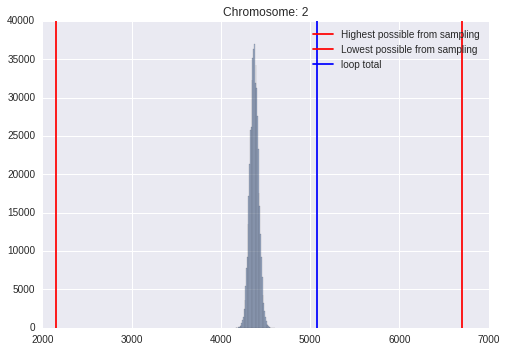

Chromosome 3
Highest possible sum from sampling: 3799
Lowest possible sum from sampling: 1136
Max from background: 2566, loop value: 2774, theoretical max: 4872


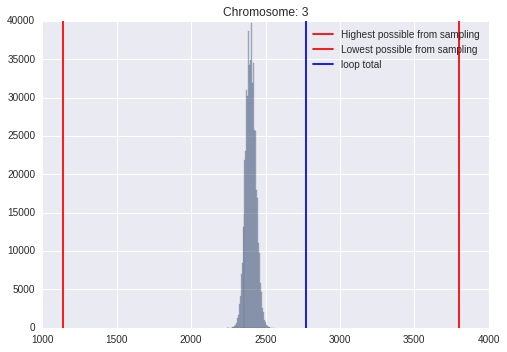

Chromosome 4
Highest possible sum from sampling: 4318
Lowest possible sum from sampling: 1698
Max from background: 3218, loop value: 3406, theoretical max: 5162


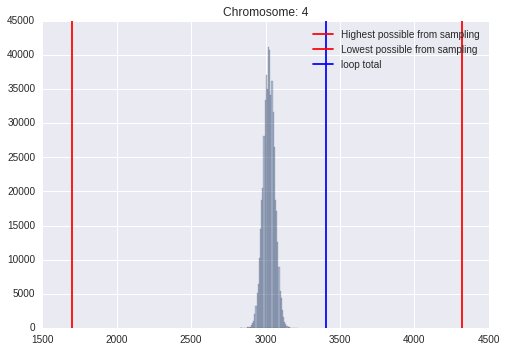

Chromosome 5
Highest possible sum from sampling: 3902
Lowest possible sum from sampling: 1420
Max from background: 2756, loop value: 2944, theoretical max: 4640


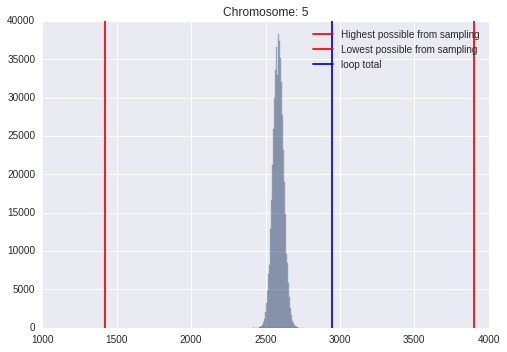

Chromosome 6
Highest possible sum from sampling: 4123
Lowest possible sum from sampling: 1428
Max from background: 2939, loop value: 3210, theoretical max: 5249


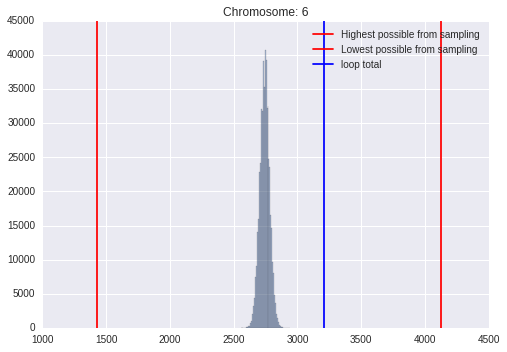

Chromosome 7
Highest possible sum from sampling: 4437
Lowest possible sum from sampling: 1380
Max from background: 3060, loop value: 3370, theoretical max: 5539


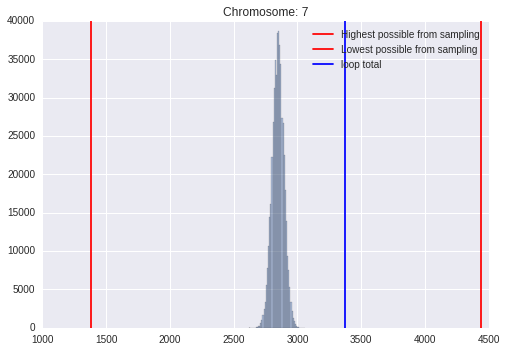

Chromosome 8
Highest possible sum from sampling: 3074
Lowest possible sum from sampling: 1002
Max from background: 2046, loop value: 2323, theoretical max: 3944


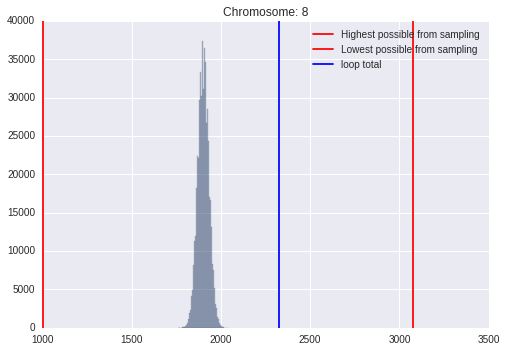

Chromosome 9
Highest possible sum from sampling: 4771
Lowest possible sum from sampling: 1606
Max from background: 3415, loop value: 3698, theoretical max: 5829


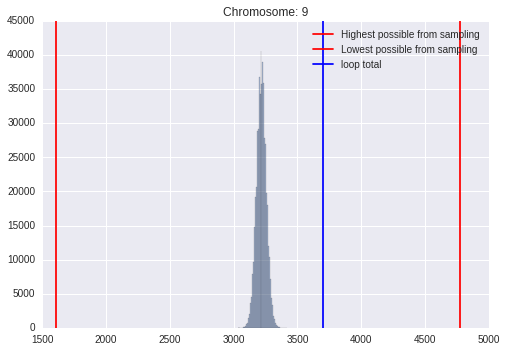

Chromosome X
Highest possible sum from sampling: 668
Lowest possible sum from sampling: 168
Max from background: 465, loop value: 490, theoretical max: 841


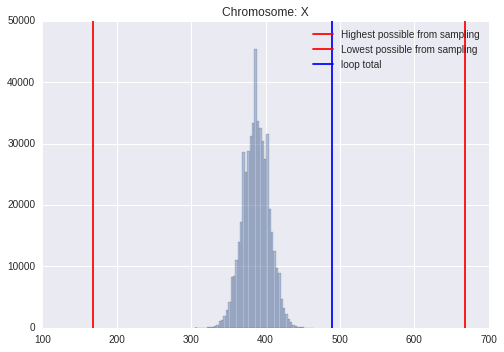

9.999999e-08
58005


In [6]:
filtered_cis = cis
contact_percentile = 90

samples = 500000

truths = 0
chrm_count = 0

total = 0

for (chrm, _), df in filtered_cis.groupby(["chr1", "chr2"]):
    chrm_count += 1
    print("Chromosome {}".format(chrm))
    dists_stack = []
    for nf in nfs:
        sc_cm = nf.trans[chrm, chrm].expr_contacts
        contact_indices = np.nonzero(sc_cm)

        sc_dists = nf.trans[chrm, chrm].dists
        contact_dists = np.sort(sc_dists[contact_indices].flatten())
        
        percentile_index = int((contact_dists.shape[0] / 100) * contact_percentile)
        
        contact_dist = contact_dists[percentile_index]
        
        dist_arr = sc_dists <= contact_dist
        dists_stack.append(dist_arr)
        
    dists_stack = np.stack(dists_stack)
    dists_count = np.sum(dists_stack, axis=0)
    
    idx_a = df["idx_a"].values
    idx_b = df["idx_b"].values
    
    # The total number of times all loop anchors contacted, across all cells.
    loop_total = np.sum(dists_count[idx_a, idx_b])
    
    total += loop_total
    
    seps = np.abs(idx_a - idx_b)
    plt.title("Chromosome: {}".format(chrm))
    (truth_count, p) = monte_carlo(dists_count, seps, loop_total, idx_a, idx_b, B=samples, plot=True, n_cells=len(nfs))
    truths += truth_count
    
print((1 + truths) / (1 + (samples * chrm_count)))
print(total)

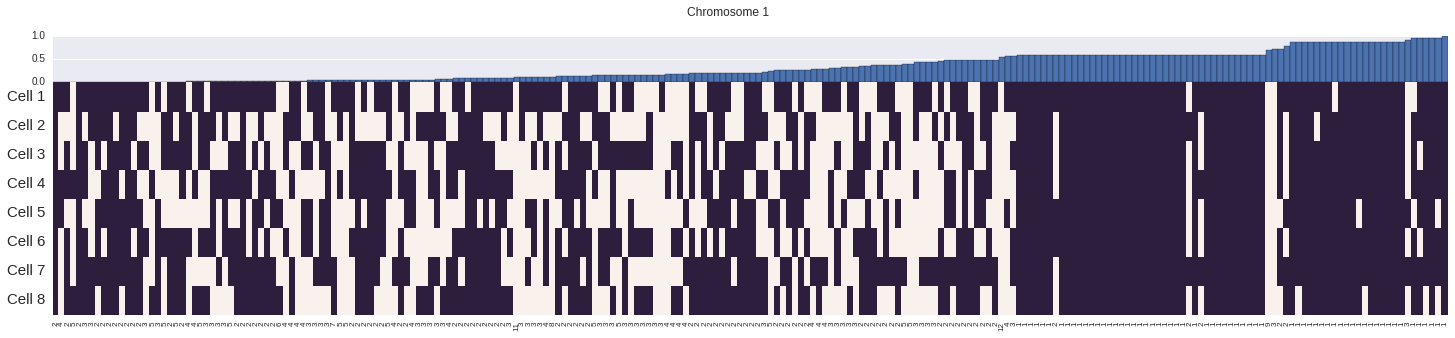

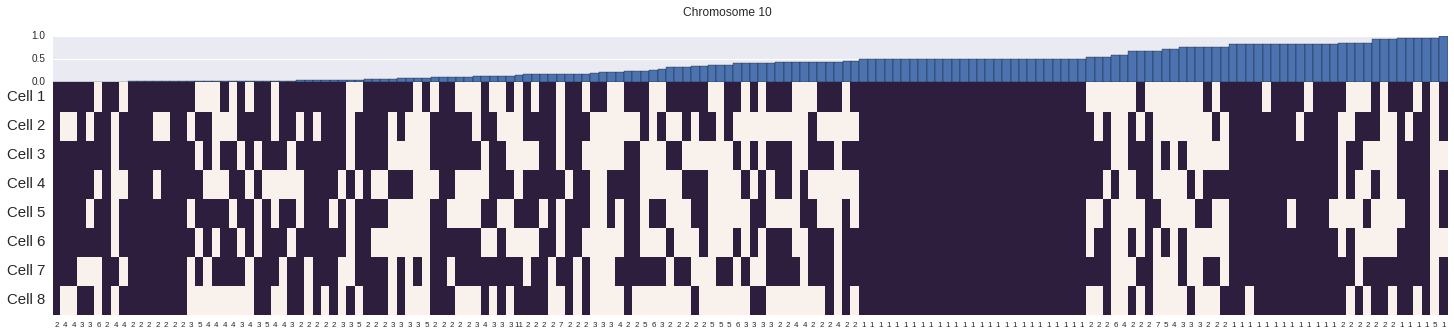

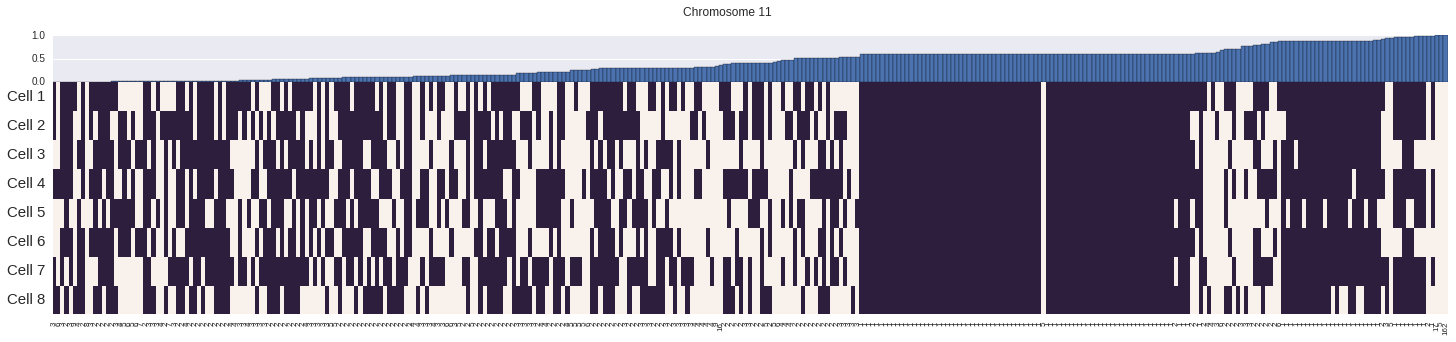

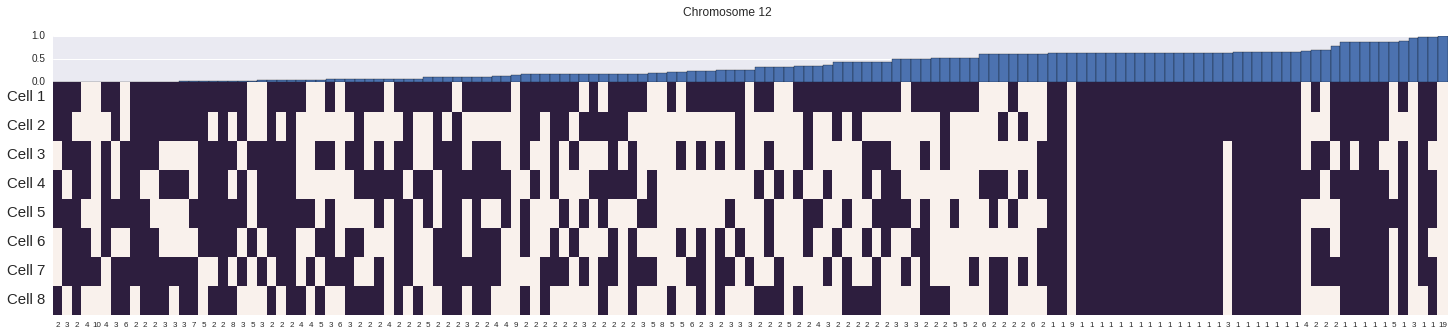

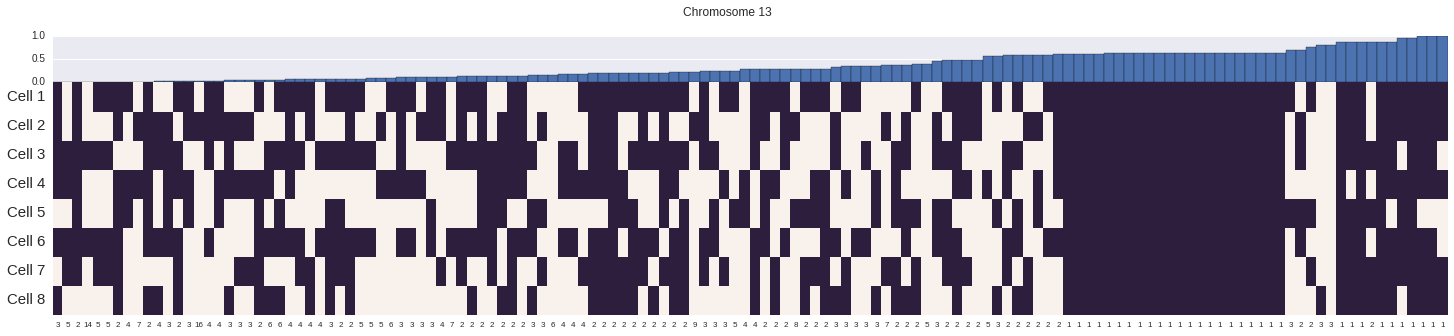

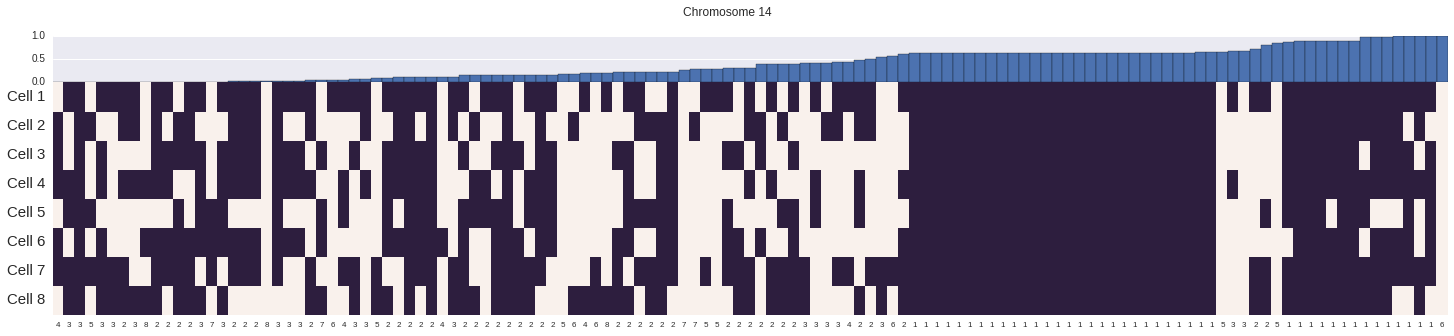

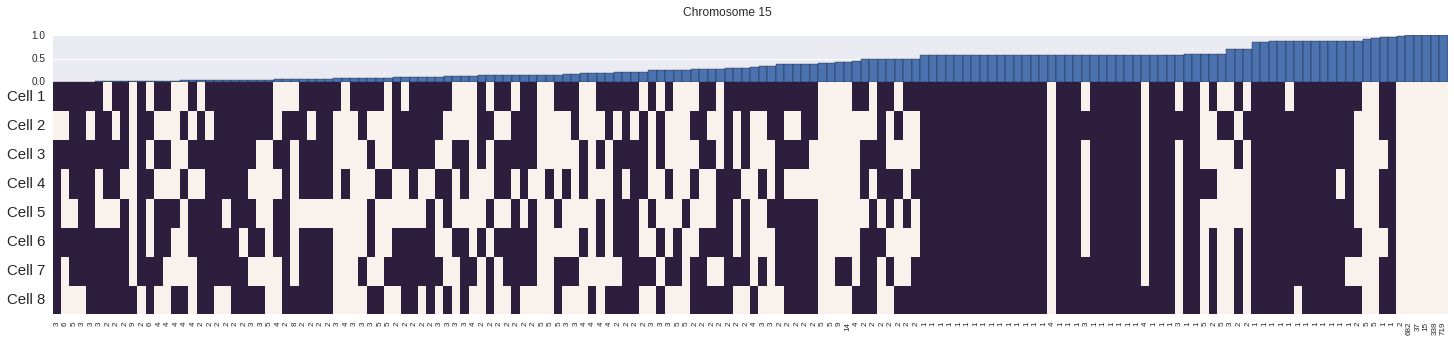

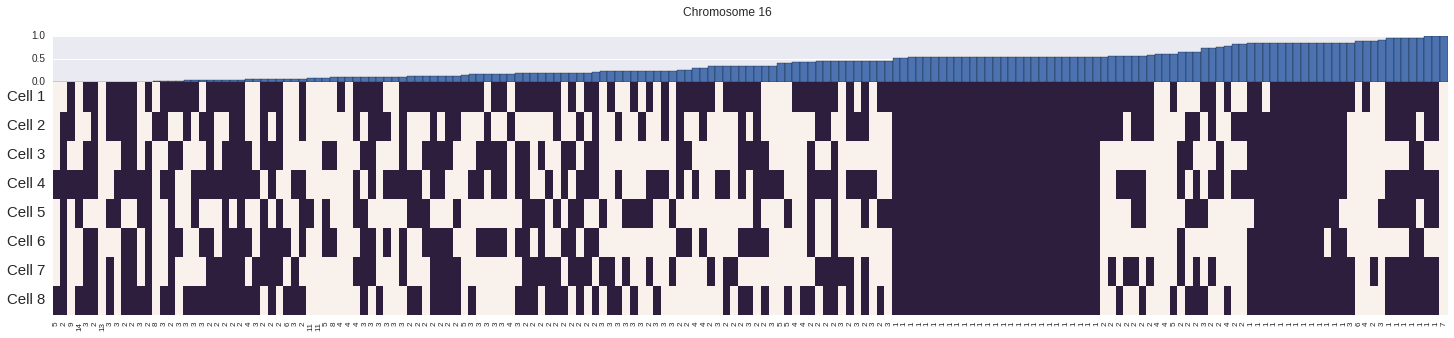

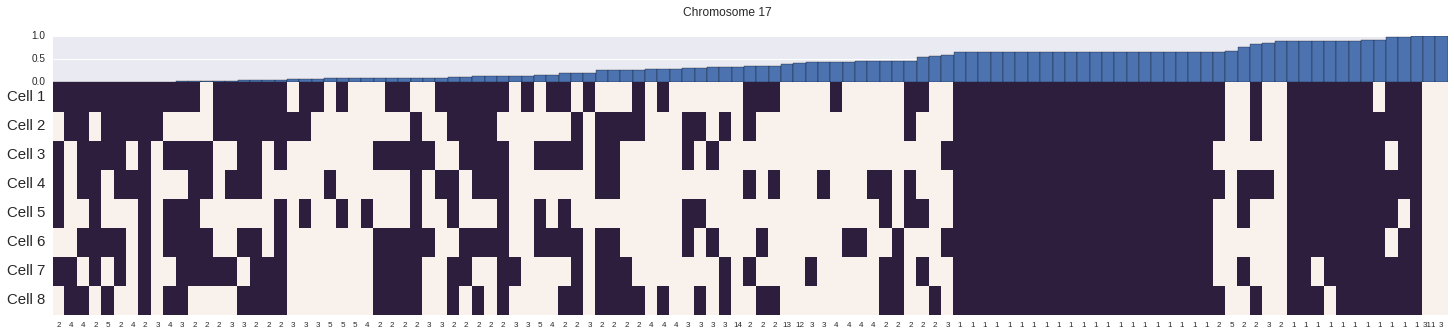

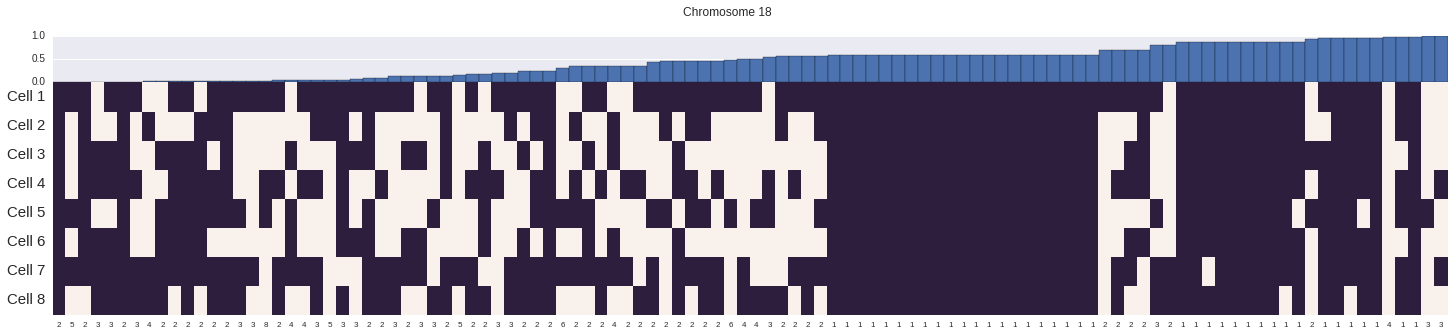

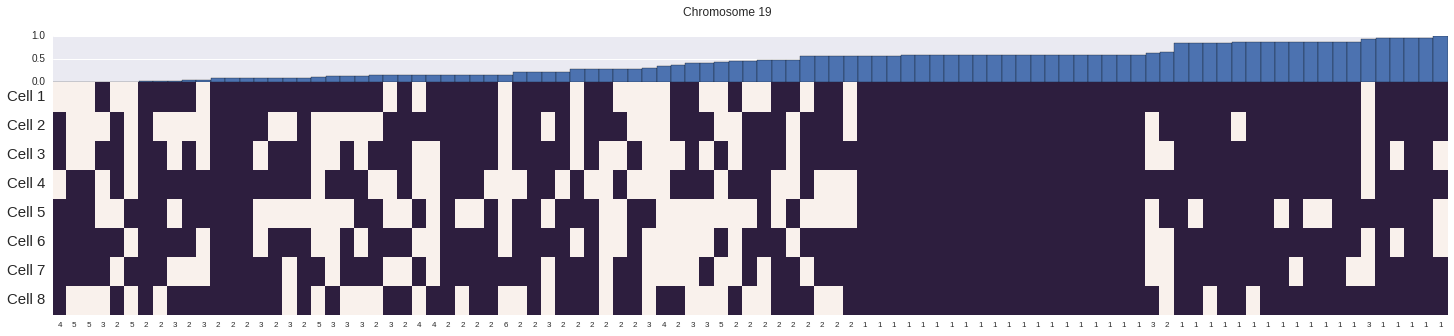

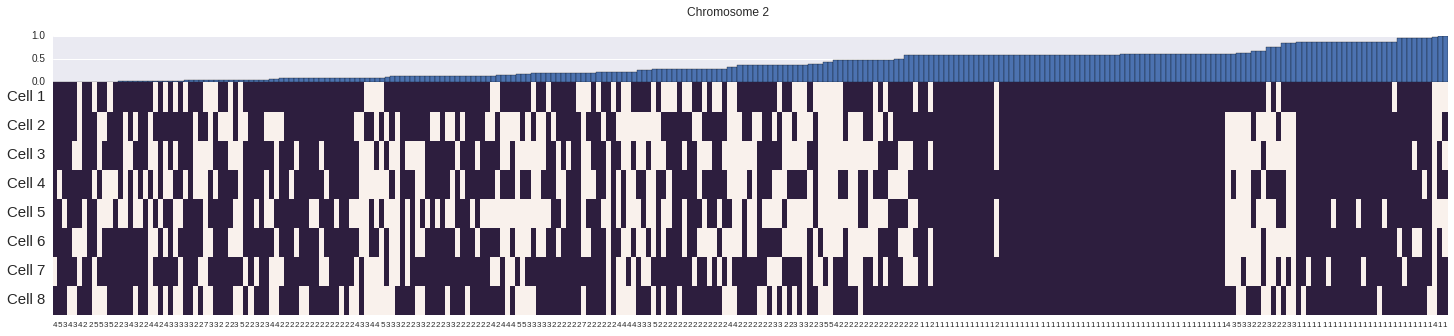

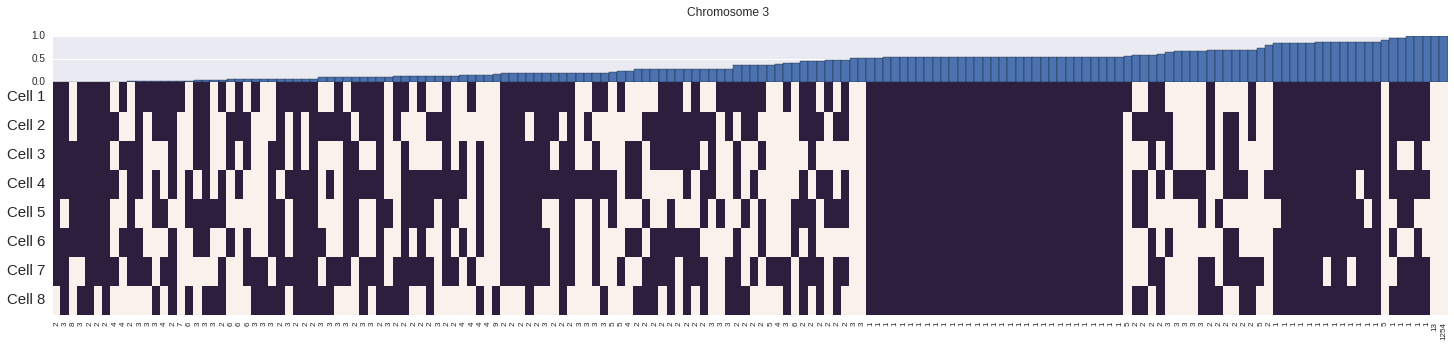

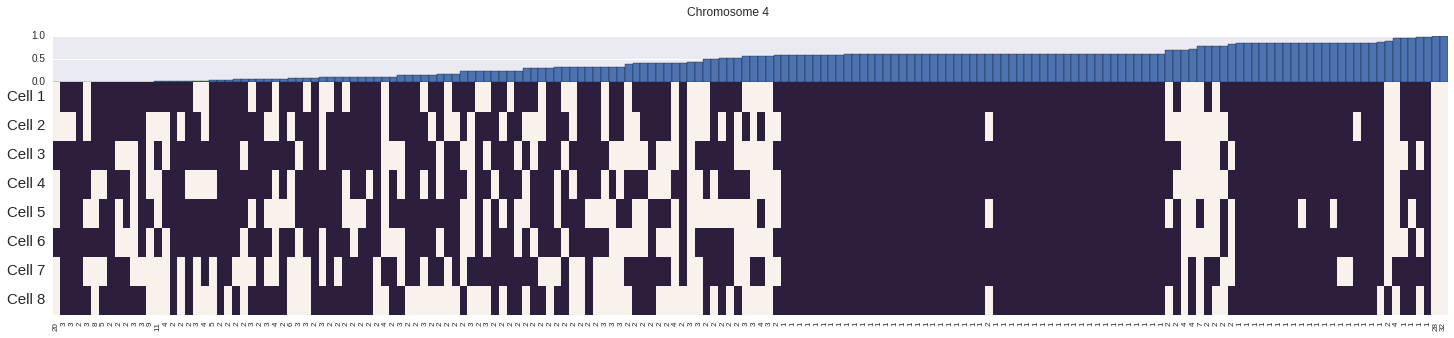

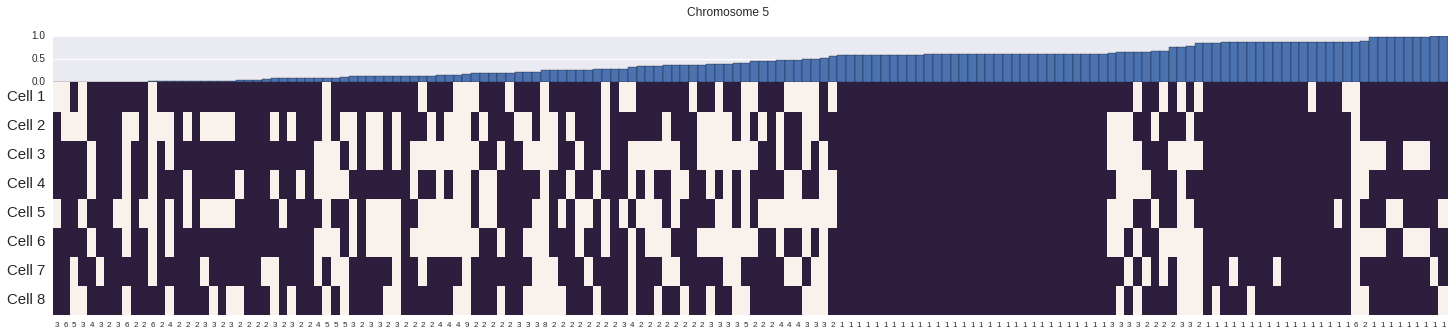

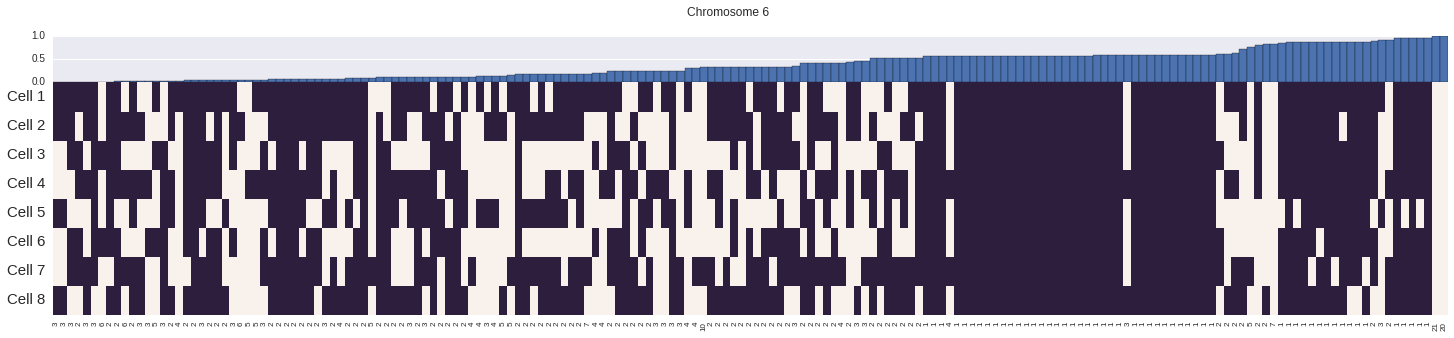

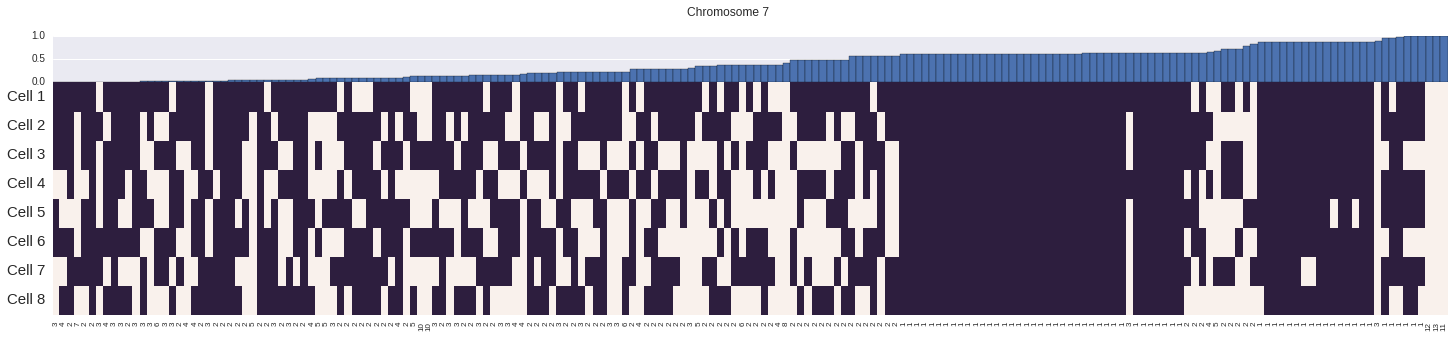

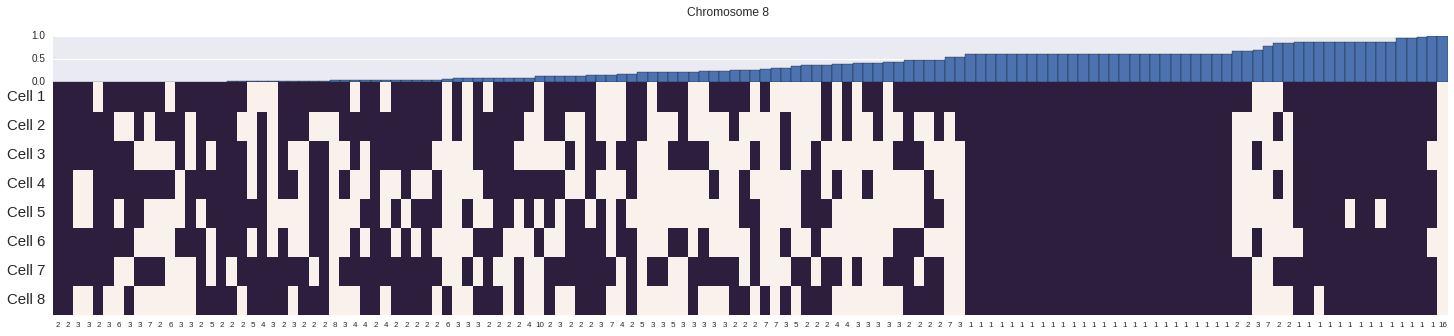

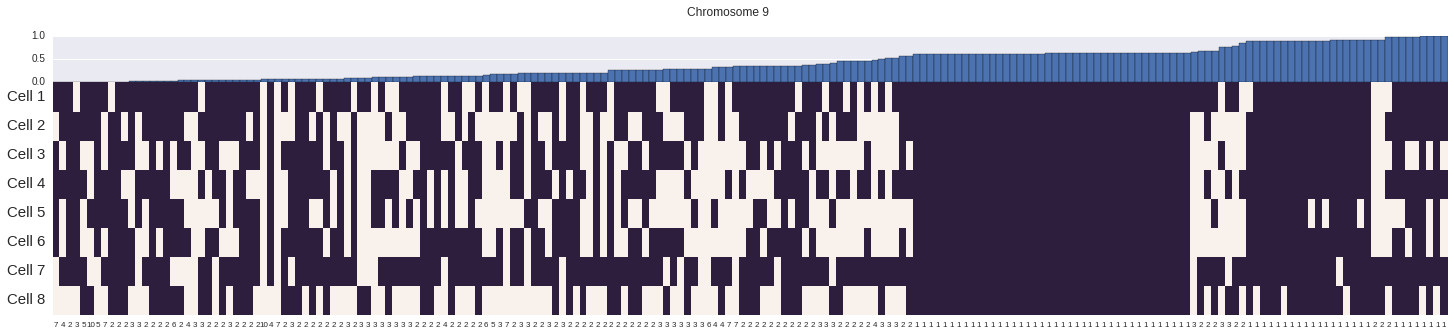

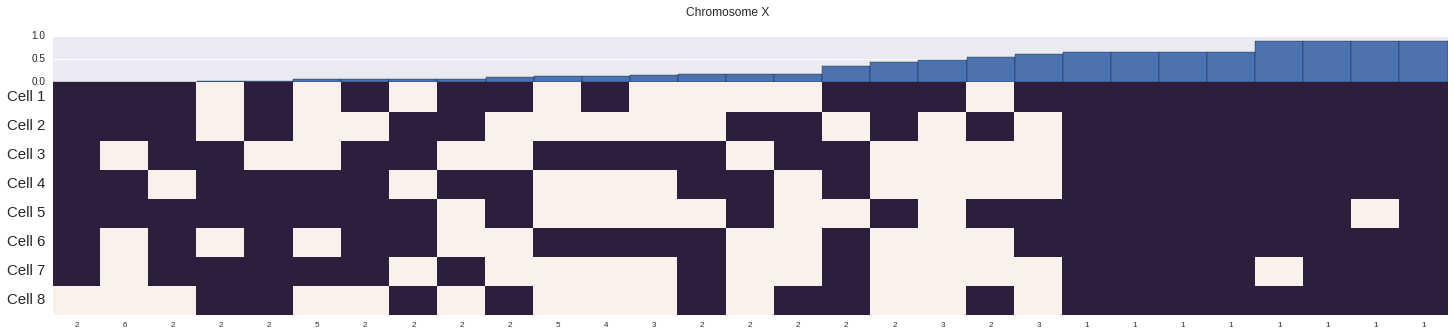

In [ ]:
contact_percentile = 90

B = 10000
ds = []
for (chrm, _), df in filtered_cis.groupby(["chr1", "chr2"]):
    idx_a = df["idx_a"]
    idx_b = df["idx_b"]
    
    d = df.copy()
    
    idx_a = d["idx_a"] = idx_a
    idx_b = d["idx_b"] = idx_b
    d["idx_sep"] = d["idx_b"] - d["idx_a"]
    #d = d[d["idx_sep"] >= 6]
    
    contact_arr_stack = []
    for label, nf in zip(cell_labels, nfs):
        sc_cm = nf.trans[chrm, chrm].expr_contacts
        contact_indices = np.nonzero(sc_cm)

        sc_dists = nf.trans[chrm, chrm].dists
        contact_dists = np.sort(sc_dists[contact_indices].flatten())
        
        percentile_index = int((contact_dists.shape[0] / 100) * contact_percentile)
        
        contact_dist = contact_dists[percentile_index]
        
        contact_arr = sc_dists <= contact_dist
        contact_arr_stack.append(contact_arr)
        d[label] = contact_arr[d["idx_a"], d["idx_b"]]
        
    sum_pseudo_contact_mat = np.sum(np.array(contact_arr_stack), axis=0)
        
    p_vals = []
    for _, row in d.iterrows():
        p = loop_monte_carlo(row.idx_a, row.idx_b, sum_pseudo_contact_mat, B=B)
        p_vals.append(p)
        
    p_vals = np.array(p_vals)
    d["loop_p_val"] = p_vals
    ds.append(d.copy())
    
    # Calculate cellwise pvalues
    seps = np.abs(idx_a - idx_b)
    cell_pval_dicts = []
    for nf in nfs:
        sc_cm = nf.trans[chrm, chrm].expr_contacts
        contact_indices = np.nonzero(sc_cm)

        sc_dists = nf.trans[chrm, chrm].dists
        contact_dists = np.sort(sc_dists[contact_indices].flatten())
        
        percentile_index = int((contact_dists.shape[0] / 100) * contact_percentile)
        
        contact_dist = contact_dists[percentile_index]
        contact_arr = sc_dists <= contact_dist
        
        cell_loop_total = np.sum(contact_arr[idx_a, idx_b])
        cell_truth_count, cell_pval = monte_carlo(contact_arr, seps, cell_loop_total, idx_a, idx_b, B=B)
        cell_pval_dicts.append({ "cell": nf.cell_name, "pval": cell_pval })
    cell_pval = pd.DataFrame(cell_pval_dicts)
        
    d = d.sort_values(by="loop_p_val", axis=0)
    
    fig = plt.figure(figsize=(25,5))
    fig.suptitle("Chromosome {}".format(chrm))
    ax = fig.add_subplot(1,1,1)
    ax.tick_params(labelsize=8, axis="x")
    ax.tick_params(labelsize=15, axis="y")

    
    main = sns.heatmap(d.ix[:, 7:15].T, ax=ax, cbar=False, xticklabels=d.idx_sep.values)
    #main.yaxis.set_yticks(rotation=0)
    for l in main.yaxis.get_ticklabels():
        l.set_rotation(0)
    divider = make_axes_locatable(ax)
    
    loop_pval_ax = divider.append_axes("top", size="20%")
    #loop_pval_ax.plot(np.arange(d.shape[0]), d.loop_p_val.values)
    #sns.barplot(np.arange(d.shape[0]), d.loop_p_val.values, ax=loop_pval_ax, color="b", linewidth=0)
    loop_pval_ax.bar(np.arange(d.shape[0]), d.loop_p_val.values, width=1)
    loop_pval_ax.set_xlim(0, d.shape[0])
    #pval_ax.get_yaxis().set_visible(False)
    loop_pval_ax.get_xaxis().set_ticks([])
    loop_pval_ax.get_yaxis().set_ticks([0, 0.5, 1.0])
    
    plt.show()